# Import packages

In [1]:
# Reading/Writing Data
import os
import glob
import numpy as np
import math 

# Pytorch
import torch 
from torch.utils.data import Subset, DataLoader

# Self-Defined Package
from SMAPDataset import SMAPDataset
from SMCNN import SMCNN
from SDLoss import self_defined_loss
from Preprocessing import random_spatial_sequence, collate_fn

# Some Utility Functions

In [2]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Training Loop

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)
    'is_train': True,
    'test_ratio': 0.2,
    'valid_ratio': 0.1,   # validation_size = train_size * valid_ratio
    'n_epochs': 5000,     # Number of epochs.            
    'train_batch_size': 50, 
    'valid_batch_size': 56,
    'test_batch_size': 1,
    'eds_lambda': 10,
    'learning_rate': 1e-4,
    'step_size': 15,
    'gamma': 0.5,
    'momentum': 0.9,
    'early_stop': 100,    # If model has not improved for this many consecutive epochs, stop training.     
    'root': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\SD\\'
}

# Dataloader
Read data from files and set up training, validation, and testing sets.

In [4]:
# # Set seed for reproducibility
same_seed(config['seed'])

##### 考虑到需要获取空间上均匀分布的站点数据，所以在每帧中随即挑选站点作为训练集，其余的作为验证集和测试集。因此使用一个字典来保存每天被筛选出来的站点list

In [5]:
train_sequence = {}
valid_sequence = {}
test_sequence = {}
s2s_dir = config['root'] + 'LABEL\\SMAPID2INSITUID'
subdir_list = sorted(os.listdir(s2s_dir))

# 遍历指定路径下的所有子目录
for subdir in subdir_list:
    subdir_path = os.path.join(s2s_dir, subdir)
    if os.path.isdir(subdir_path):
        # 如果子目录是目录而不是文件，则将子目录加入字典
        full_spatial_sequence_smap = sorted([int(f.split('.')[0]) for f in os.listdir(subdir_path) if f.endswith('.npy')]) # !!!! read out of order
        print(len(full_spatial_sequence_smap), 'of Full Spatial Sequence for', subdir, ':')
        print(full_spatial_sequence_smap)
        
        # Split the train\valid\test dataset by spatial dimension
        train_sequence[subdir], test_sequence[subdir] = random_spatial_sequence(1-config['test_ratio'], full_spatial_sequence_smap)
        train_sequence[subdir], valid_sequence[subdir] = random_spatial_sequence(1-config['valid_ratio'], train_sequence[subdir])

10 of Full Spatial Sequence for 2015104 :
[9, 15, 17, 18, 20, 26, 29, 31, 40, 43]
**************************Data Spliting***************************
Spliting Rate:  0.8
8 of Dataset1:  [15 31 18 40 29 17 43 26]
2 of Dataset2:  [ 9 20]
**************************Data Spliting***************************
**************************Data Spliting***************************
Spliting Rate:  0.9
7 of Dataset1:  [17 18 29 43 40 26 15]
1 of Dataset2:  [31]
**************************Data Spliting***************************
6 of Full Spatial Sequence for 2015106 :
[15, 16, 20, 26, 27, 29]
**************************Data Spliting***************************
Spliting Rate:  0.8
4 of Dataset1:  [16 26 20 27]
2 of Dataset2:  [15 29]
**************************Data Spliting***************************
**************************Data Spliting***************************
Spliting Rate:  0.9
3 of Dataset1:  [27 26 16]
1 of Dataset2:  [20]
**************************Data Spliting***************************
4 of Ful

In [6]:
# Initialize the dataset
train_dataset = SMAPDataset(config['root'], train_sequence)
valid_dataset = SMAPDataset(config['root'], valid_sequence)
test_dataset = SMAPDataset(config['root'], test_sequence)

# 选择标签值为大于0的样本作为训练集
train_indices = [i for i in range(len(train_dataset)) if 0 not in [x[0] for x in train_dataset[i]['label_data']]]
train_subset = Subset(train_dataset, train_indices)
valid_indices = [i for i in range(len(valid_dataset)) if 0 not in [x[0] for x in valid_dataset[i]['label_data']]]
valid_subset = Subset(valid_dataset, valid_indices)

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_subset, batch_size=config['train_batch_size'], shuffle=True, pin_memory=True, collate_fn=collate_fn, drop_last=True)
valid_loader = DataLoader(valid_subset, batch_size=config['valid_batch_size'], shuffle=True, pin_memory=True, collate_fn=collate_fn, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=config['test_batch_size'], shuffle=False, pin_memory=True, collate_fn=collate_fn, drop_last=False)

***************************Load data path******************************
_______________________________2015104_______________________________
_____________________________smap cell: 17_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\INPUT\SMAP\2015104\17.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\INPUT\TEXTURE\17.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\LABEL\SM\2015104\18.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\LABEL\ATI\2015104\18.npy
_____________________________smap cell: 18_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\INPUT\SMAP\2015104\18.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\INPUT\TEXTURE\18.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\LABEL\SM\2015104\31.npy
D:\1GRADUATED\p

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\LABEL\ATI\2015171\32.npy
_____________________________smap cell: 41_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\INPUT\SMAP\2015171\41.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\INPUT\TEXTURE\41.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\LABEL\SM\2015171\6.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\LABEL\ATI\2015171\6.npy
_____________________________smap cell: 20_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\INPUT\SMAP\2015171\20.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\INPUT\TEXTURE\20.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\LABEL\SM\2015171\27.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downsca

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\INPUT\TEXTURE\9.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\LABEL\SM\2015288\55.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\LABEL\ATI\2015288\55.npy
_____________________________smap cell: 33_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\INPUT\SMAP\2015288\33.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\INPUT\TEXTURE\33.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\LABEL\SM\2015288\32.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\LABEL\ATI\2015288\32.npy
_____________________________smap cell: 45_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\INPUT\SMAP\2015288\45.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downsc

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\LABEL\SM\2015138\25.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\LABEL\ATI\2015138\25.npy
_______________________________2015149_______________________________
_____________________________smap cell: 15_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\INPUT\SMAP\2015149\15.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\INPUT\TEXTURE\15.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\LABEL\SM\2015149\4.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\LABEL\ATI\2015149\4.npy
_______________________________2015160_______________________________
_______________________________2015162_______________________________
_____________________________smap cell: 15_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moist

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\LABEL\ATI\2015291\37.npy
_______________________________2015296_______________________________
_____________________________smap cell: 26_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\INPUT\SMAP\2015296\26.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\INPUT\TEXTURE\26.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\LABEL\SM\2015296\40.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\LABEL\ATI\2015296\40.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\LABEL\SM\2015296\25.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\SD\LABEL\ATI\2015296\25.npy
_______________________________2015330_______________________________
_____________________________smap cell: 9_____________________________
D:\1GRADUATED\p

In [7]:
print(train_dataset.__len__())
print(valid_dataset.__len__())
print(test_dataset.__len__())

251
56
102


# Data visualization

In [8]:
import matplotlib.pyplot as plt

In [9]:
def display_data_spatial_distribution(full_smapid_sequence, dict_sequence, data_name, root, seed):
    # 创建一个空数组
    bg_scale = -10
    z_scale = -5
    verified_mat = np.ones((7,13))
    verified_mat = verified_mat * bg_scale
    verified_mat[0][2:7] = z_scale
    verified_mat[1][0:8] = z_scale
    verified_mat[2][0:10] = z_scale
    verified_mat[3][0:12] = z_scale
    verified_mat[4][2:13] = z_scale
    verified_mat[5][6:13] = z_scale
    verified_mat[6][7:12] = z_scale
    row_i = np.where(verified_mat!=bg_scale)[0]
    col_j = np.where(verified_mat!=bg_scale)[1]
    
    # 确定cell数据量的大小
    for smapid in full_smapid_sequence:
        y = [key for key, value in dict_sequence.items() if smapid in value]
        verified_mat[row_i[smapid]][col_j[smapid]] = len(y)

    plt.figure(figsize=(13,7))
    plt.imshow(verified_mat, alpha=0.8, extent=[0, 13, 0, 7], vmin=-10, vmax=20, cmap='coolwarm')
    
    # 设置图形标题
    plt.title('Number of {} Data in Each Cell'.format(data_name))
    plt.xticks(range(14))
    plt.grid(True)
    plt.colorbar()
    
#     # 显示图形
#     plt.savefig(root + 'OUTPUT\\IMAGE\\DATAVISUALIZE\\CNN\\' + str(seed) + '\\' + data_name + 'DataSpatialDistribution.png', dpi=600, transparent=False)    
#     plt.show()


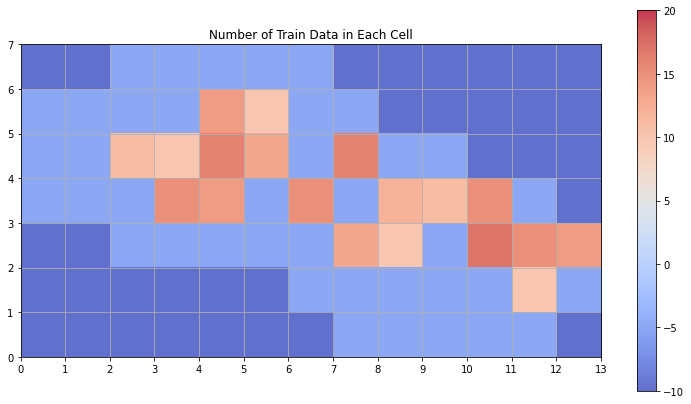

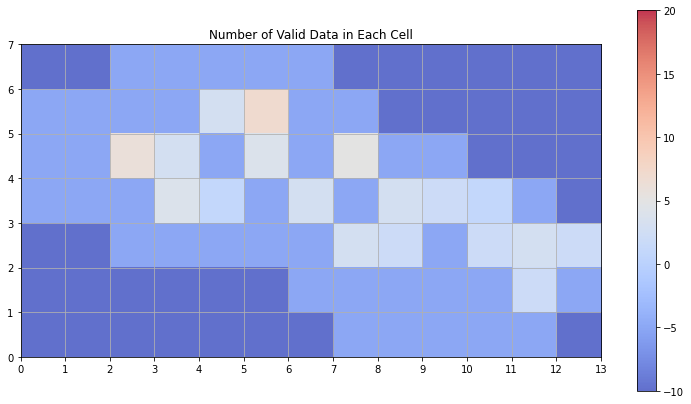

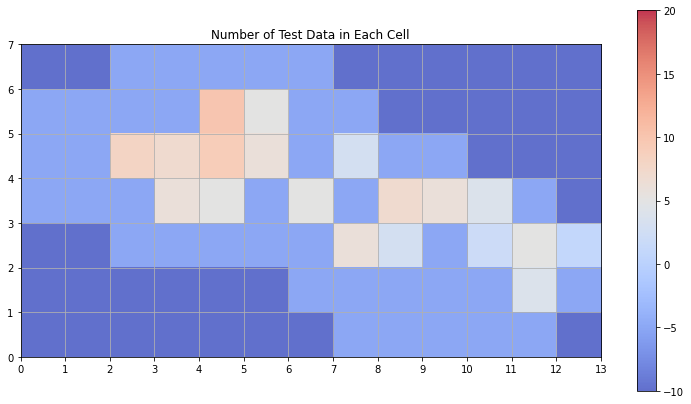

In [10]:
train_full_smapid_sequence = train_dataset.get_full_smapid_sequence()
valid_full_smapid_sequence = valid_dataset.get_full_smapid_sequence()
test_full_smapid_sequence = test_dataset.get_full_smapid_sequence()

display_data_spatial_distribution(train_full_smapid_sequence, train_sequence, 'Train', config['root'], config['seed'])
display_data_spatial_distribution(valid_full_smapid_sequence, valid_sequence, 'Valid', config['root'], config['seed'])
display_data_spatial_distribution(test_full_smapid_sequence, test_sequence, 'Test', config['root'], config['seed'])

In [11]:
def display_data_temporal_distribution(full_smapid_sequence, dict_sequence, data_name, root, seed):
    # 绘制散点图
    plt.figure(figsize=(6, 3))

    X = range(len(full_smapid_sequence))
    for i, smapid in enumerate(full_smapid_sequence):
        y = [int(key.split('2015')[1]) for key, value in dict_sequence.items() if smapid in value]
        x = [i] * len(y)  # 重复 X 坐标以便绘制多个散点
        plt.scatter(x, y)

    # 设置图形标题和坐标轴标签
    plt.title(data_name + ' Time Sequence Distribution for Each SMAP Cell')
    plt.xlabel("SMAPID")
    plt.ylabel("Day")
    plt.xticks(X, list(full_smapid_sequence))
    plt.yticks(np.arange(90, 360, 20))

#     # 显示图形
#     plt.savefig(root + 'OUTPUT\\IMAGE\\DATAVISUALIZE\\CNN\\' + str(seed) + '\\' + data_name + 'DataTemporalDistribution.png', dpi=600, transparent=False)    
#     plt.show()

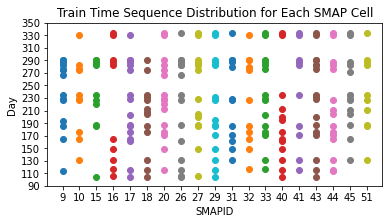

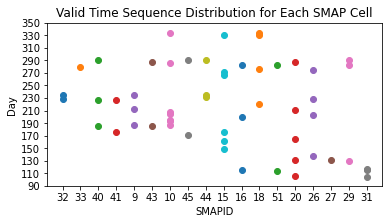

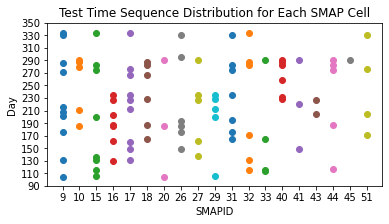

In [12]:
train_full_smapid_sequence = train_dataset.get_full_smapid_sequence()
valid_full_smapid_sequence = valid_dataset.get_full_smapid_sequence()
test_full_smapid_sequence = test_dataset.get_full_smapid_sequence()

display_data_temporal_distribution(train_full_smapid_sequence, train_sequence, 'Train', config['root'], config['seed'])
display_data_temporal_distribution(valid_full_smapid_sequence, valid_sequence, 'Valid', config['root'], config['seed'])
display_data_temporal_distribution(test_full_smapid_sequence, test_sequence, 'Test', config['root'], config['seed'])

# Start training!

In [13]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = self_defined_loss 
    optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum']) 
    
    # learning rate decay
#     ExpLR = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
#     MultiStepLR = torch.optim.lr_scheduler.MultiStepLR(optimizer_MultiStepLR,
#                     milestones=[200, 300, 320, 340, 200], gamma=0.8)
#     CosineLR = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_CosineLR, T_max=150, eta_min=0)
    RLRP = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=config['gamma'], patience=config['step_size'], threshold=0.03)
#     StepLR = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config['step_size'], gamma=config['gamma'])

    
    if not os.path.isdir(config['root'] + '\\OUTPUT\\MODELS\\'):
        os.mkdir(config['root'] + '\\OUTPUT\\MODELS\\') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        
        loss_record = []
        physical_loss_record = []
        eds_loss_record = []
        for data_pkg in train_loader:
            x = data_pkg['processed_data']
            optimizer.zero_grad()               # Set gradient to zero.
            pred = model(x)
#             x, pred = x.to(device), pred.to(device)   # Move your data to device. 
            
            physical_loss, eds_loss = criterion(pred, data_pkg['label_data'], config['train_batch_size'], config['eds_lambda'], 'Training')
            loss = physical_loss + eds_loss
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            physical_loss_record.append(physical_loss.detach().item())
            eds_loss_record.append(eds_loss.detach().item())
            
        mean_train_physical_loss = sum(physical_loss_record)/len(physical_loss_record)
        mean_train_eds_loss = sum(eds_loss_record)/len(eds_loss_record)
        mean_train_loss = sum(loss_record)/len(loss_record)
        
        model.eval() # Set your model to evaluation mode.
        loss_record = []
        physical_loss_record = []
        eds_loss_record = []
        for data_pkg in valid_loader:
            x = data_pkg['processed_data']
            with torch.no_grad():
                pred = model(x)
#                 print(data_pkg['label_data'])
#             x, pred = x.to(device), pred.to(device)   # Move your data to device. 
                physical_loss, eds_loss = criterion(pred, data_pkg['label_data'], config['train_batch_size'], config['eds_lambda'], 'Validing')
                loss = physical_loss + eds_loss
        
            loss_record.append(loss.item())
            physical_loss_record.append(physical_loss.item())
            eds_loss_record.append(eds_loss.item())
        
        print(loss_record)
        mean_valid_loss = sum(loss_record)/len(loss_record)
        mean_valid_eds_loss = sum(eds_loss_record)/len(eds_loss_record)
        mean_valid_physical_loss = sum(physical_loss_record)/len(physical_loss_record)
        
        current_lr = (optimizer.param_groups[0])['lr']
        print(f'Epoch [{epoch+1}/{n_epochs}] (LR: {current_lr}):')
        print(f'Train loss: {mean_train_loss:.4f} || Train physical loss: {mean_train_physical_loss:.4f} || Train eds loss: {mean_train_eds_loss:.4f}')
        print(f'Valid loss: {mean_valid_loss:.4f} || Valid physical loss: {mean_valid_physical_loss:.4f} || Valid eds loss: {mean_valid_eds_loss:.4f}')
         
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            _name = str(best_loss)
            _name = 'output'
            torch.save(model.state_dict(), config['root'] + '\\OUTPUT\\MODELS\\CNN\\' + _name + '.ckpt') # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            _name = str(best_loss)
            _name = 'output'
            torch.save(model.state_dict(), config['root'] + '\\OUTPUT\\MODELS\\CNN\\' + _name + '.ckpt') # Save your best model
            return
        #         StepLR.step()
        RLRP.step(mean_valid_loss)

(11, 11, 19)
SMCNN(
  (cnn): Sequential(
    (0): Conv2d(19, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3872, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
)
sd_pred: tensor([-0.0109, -0.0085, -0.0084, -0.0085, -0.0122, -0.0122, -0.0111, -0.0050,
        -0.0124, -0.0102, -0.0096, -0.0101, -0.0097, -0.0093, -0.0010, -0.0009,
        -0.0096, -0.0136, -0.0108, -0.0137, -0.0095, -0.0107, -0.0010, -0.0095,
        -0.0051, -0.0100, -0.0087, -0.0048, -0.0058, -0.0100, -0.0112, -0.0050,
        -0.0122, -0.0097, -0.0138, -0.0099, -0.0097, -0.0057, -0.0078])


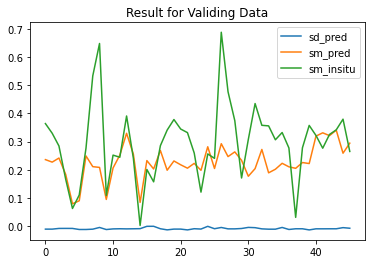

[9.94563102722168]
Epoch [1/5000] (LR: 0.0001):
Train loss: 9.6226 || Train physical loss: 0.1423 || Train eds loss: 9.4803
Valid loss: 9.9456 || Valid physical loss: 0.0171 || Valid eds loss: 9.9285
Saving model with loss 9.946...
sd_pred: tensor([-0.0231, -0.0282, -0.0231, -0.0311, -0.0230, -0.0311, -0.0226, -0.0220,
        -0.0234, -0.0185, -0.0236, -0.0212, -0.0232, -0.0210, -0.0225, -0.0312,
        -0.0235, -0.0281, -0.0210, -0.0216, -0.0217, -0.0215, -0.0220, -0.0259,
        -0.0245, -0.0216, -0.0242, -0.0311, -0.0282, -0.0220, -0.0185, -0.0217,
        -0.0291, -0.0161, -0.0185, -0.0290, -0.0221, -0.0217, -0.0289])


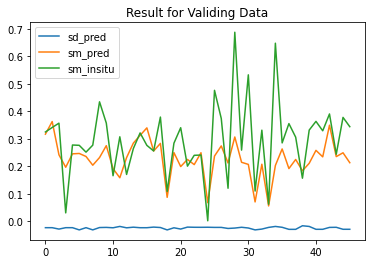

[9.931303024291992]
Epoch [2/5000] (LR: 0.0001):
Train loss: 9.8720 || Train physical loss: 0.0208 || Train eds loss: 9.8512
Valid loss: 9.9313 || Valid physical loss: 0.0163 || Valid eds loss: 9.9150
Saving model with loss 9.931...
sd_pred: tensor([-0.0138, -0.0266, -0.0232, -0.0166, -0.0073, -0.0295, -0.0232, -0.0181,
        -0.0104, -0.0295, -0.0137, -0.0064, -0.0231, -0.0073, -0.0295, -0.0074,
        -0.0137, -0.0082, -0.0082, -0.0266, -0.0177, -0.0073, -0.0166, -0.0198,
        -0.0177, -0.0081, -0.0077, -0.0177, -0.0073, -0.0118, -0.0295, -0.0268,
        -0.0072, -0.0077, -0.0198, -0.0077, -0.0110, -0.0181, -0.0117])


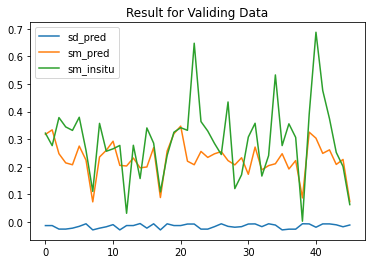

[9.840962409973145]
Epoch [3/5000] (LR: 0.0001):
Train loss: 9.8538 || Train physical loss: 0.1207 || Train eds loss: 9.7331
Valid loss: 9.8410 || Valid physical loss: 0.0164 || Valid eds loss: 9.8245
Saving model with loss 9.841...
sd_pred: tensor([ 0.0153, -0.0017,  0.0273,  0.0186,  0.0273,  0.0202, -0.0190,  0.0202,
         0.0034, -0.0188,  0.0273, -0.0207,  0.0273, -0.0108, -0.0188, -0.0108,
         0.0117,  0.0117, -0.0207, -0.0015, -0.0039,  0.0141,  0.0034,  0.0202,
        -0.0207,  0.0264,  0.0273,  0.0273,  0.0117, -0.0016,  0.0264, -0.0051,
         0.0263, -0.0054, -0.0207, -0.0108,  0.0202, -0.0054,  0.0196])


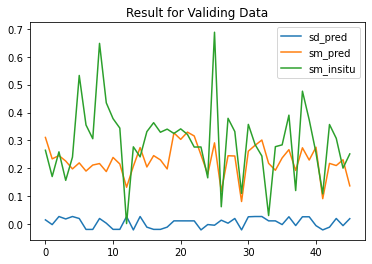

[9.62753963470459]
Epoch [4/5000] (LR: 0.0001):
Train loss: 9.5960 || Train physical loss: 0.1049 || Train eds loss: 9.4911
Valid loss: 9.6275 || Valid physical loss: 0.0177 || Valid eds loss: 9.6098
Saving model with loss 9.628...
sd_pred: tensor([ 0.0841,  0.0841, -0.0234,  0.0061, -0.0234,  0.0525,  0.0840,  0.0026,
         0.0525,  0.0612, -0.0114,  0.0840,  0.0294,  0.0526,  0.0841,  0.0612,
        -0.0234, -0.0014, -0.0014, -0.0113, -0.0018,  0.0676,  0.0721, -0.0234,
        -0.0114,  0.0610,  0.0062,  0.0805,  0.0061, -0.0234,  0.0293,  0.0524,
         0.0805,  0.0841,  0.0805, -0.0234,  0.0529,  0.0535, -0.0234])


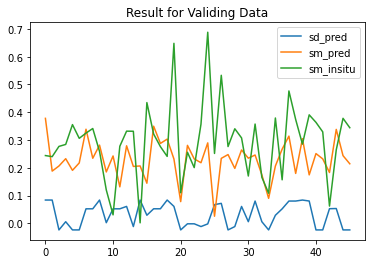

[9.14009952545166]
Epoch [5/5000] (LR: 0.0001):
Train loss: 9.0844 || Train physical loss: 0.0297 || Train eds loss: 9.0547
Valid loss: 9.1401 || Valid physical loss: 0.0212 || Valid eds loss: 9.1189
Saving model with loss 9.140...
sd_pred: tensor([ 0.1202,  0.1702,  0.0095,  0.0219, -0.0183,  0.1916,  0.1409,  0.0095,
         0.1998, -0.0135, -0.0174,  0.1358, -0.0183,  0.1913, -0.0175, -0.0132,
         0.0826,  0.0830,  0.1431,  0.1996,  0.1340,  0.1838,  0.1429, -0.0009,
         0.1992, -0.0174,  0.1987, -0.0131,  0.0205,  0.1404, -0.0183,  0.1993,
        -0.0174,  0.1431,  0.1996,  0.0203,  0.1914,  0.1404,  0.0211])


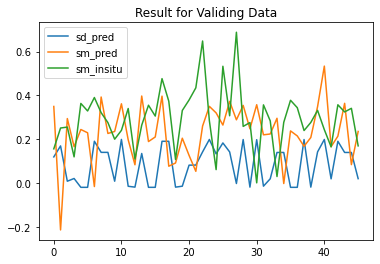

[8.312251091003418]
Epoch [6/5000] (LR: 0.0001):
Train loss: 8.2950 || Train physical loss: 0.1148 || Train eds loss: 8.1802
Valid loss: 8.3123 || Valid physical loss: 0.0369 || Valid eds loss: 8.2753
Saving model with loss 8.312...
sd_pred: tensor([-0.0068,  0.2787, -0.0135,  0.0226,  0.3006,  0.3898,  0.0227,  0.1647,
         0.4048,  0.2740, -0.0152,  0.4060,  0.3904,  0.2781,  0.3020,  0.2714,
         0.4060,  0.3826, -0.0115,  0.4069,  0.2393, -0.0152,  0.0562, -0.0134,
         0.3900, -0.0115, -0.0152,  0.0308, -0.0115,  0.0297,  0.4046, -0.0134,
         0.2787, -0.0134,  0.1641,  0.3574,  0.0293,  0.4028,  0.3008])


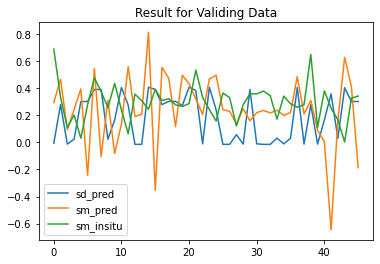

[7.093414783477783]
Epoch [7/5000] (LR: 0.0001):
Train loss: 7.2195 || Train physical loss: 0.1644 || Train eds loss: 7.0551
Valid loss: 7.0934 || Valid physical loss: 0.0922 || Valid eds loss: 7.0013
Saving model with loss 7.093...
sd_pred: tensor([ 0.4850, -0.0091, -0.0106,  0.7328,  0.7302,  0.7124,  0.0401, -0.0128,
        -0.0090,  0.6606,  0.1227,  0.4731,  0.2821,  0.0367, -0.0128, -0.0106,
         0.0489,  0.7328,  0.7111,  0.7346,  0.4851,  0.4334,  0.4981,  0.2832,
         0.0377, -0.0128, -0.0046,  0.6940,  0.4837,  0.7267,  0.7107, -0.0091,
         0.5599,  0.5575,  0.5572, -0.0106, -0.0106,  0.0488,  0.7304])


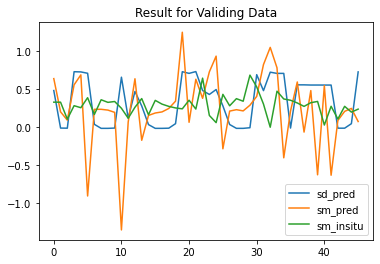

[5.75179386138916]
Epoch [8/5000] (LR: 0.0001):
Train loss: 6.3374 || Train physical loss: 0.7508 || Train eds loss: 5.5866
Valid loss: 5.7518 || Valid physical loss: 0.2534 || Valid eds loss: 5.4984
Saving model with loss 5.752...
sd_pred: tensor([ 1.0621, -0.0126,  0.1511, -0.0105, -0.0126,  0.0266,  0.9801, -0.0092,
        -0.0092, -0.0092,  0.8045,  1.0818,  0.0265, -0.0052,  0.7116,  0.6414,
         1.0845,  1.0778, -0.0123, -0.0105,  1.0601, -0.0123,  0.8040,  1.0782,
        -0.0105,  0.6431,  0.6307,  0.8080,  1.0596,  0.6253, -0.0105,  1.0818,
        -0.0126,  0.6432,  0.3369, -0.0123,  1.0168,  0.3386,  1.0723])


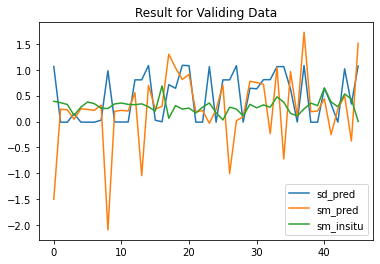

[4.854824066162109]
Epoch [9/5000] (LR: 0.0001):
Train loss: 5.7887 || Train physical loss: 1.4402 || Train eds loss: 4.3485
Valid loss: 4.8548 || Valid physical loss: 0.5045 || Valid eds loss: 4.3503
Saving model with loss 4.855...
sd_pred: tensor([ 0.5706,  0.5657, -0.0143, -0.0143,  0.8666,  1.2645, -0.0143,  0.0219,
         1.1354,  0.8630,  0.6800, -0.0143,  0.1953, -0.0128, -0.0143, -0.0080,
         1.2729, -0.0118, -0.0118,  0.5655,  0.8625, -0.0128, -0.0143,  1.2697,
         1.2576, -0.0143,  1.2489,  0.7604,  1.1606, -0.0128, -0.0118,  1.2485,
         0.5636,  0.1932, -0.0128,  1.2649, -0.0143,  1.2697,  1.2506])


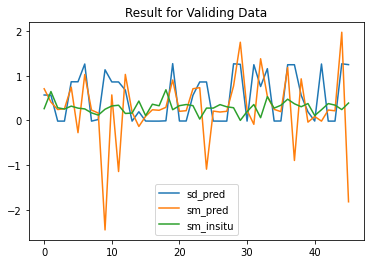

[4.530848026275635]
Epoch [10/5000] (LR: 0.0001):
Train loss: 5.5786 || Train physical loss: 1.8060 || Train eds loss: 3.7727
Valid loss: 4.5308 || Valid physical loss: 0.6229 || Valid eds loss: 3.9079
Saving model with loss 4.531...
sd_pred: tensor([ 0.6709, -0.0154, -0.0154, -0.0169, -0.0169,  1.3456, -0.0126, -0.0169,
         1.3418, -0.0160, -0.0160,  1.3322, -0.0169, -0.0154, -0.0169, -0.0169,
        -0.0169, -0.0126,  1.3354,  1.3456,  0.7287,  1.3483,  1.1927,  1.3414,
         0.4174, -0.0169,  0.8210,  0.8167,  0.3941, -0.0160, -0.0117,  1.1882,
         0.3943,  1.3346, -0.0169, -0.0160,  0.8161,  1.3327,  0.3921])


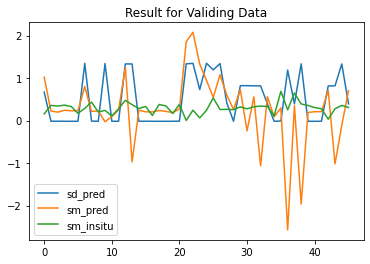

[4.4171366691589355]
Epoch [11/5000] (LR: 0.0001):
Train loss: 5.3164 || Train physical loss: 1.8240 || Train eds loss: 3.4924
Valid loss: 4.4171 || Valid physical loss: 0.6442 || Valid eds loss: 3.7729
Saving model with loss 4.417...
sd_pred: tensor([ 0.2463,  0.7098,  0.6809, -0.0195,  0.7720, -0.0163,  0.7665,  0.7671,
         1.4080,  1.4039,  1.3993, -0.0195, -0.0200, -0.0200, -0.0195, -0.0163,
         1.3987, -0.0200,  1.4014, -0.0200, -0.0192, -0.0200, -0.0200, -0.0200,
         1.4104,  1.2327,  1.4080, -0.0200, -0.0192, -0.0016,  1.2144,  0.2439,
        -0.0192, -0.0195, -0.0200,  0.2875,  0.2465,  1.3971,  1.4035])


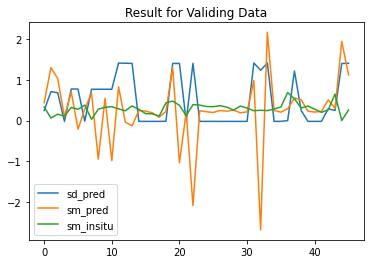

[4.348795413970947]
Epoch [12/5000] (LR: 0.0001):
Train loss: 5.3913 || Train physical loss: 1.8262 || Train eds loss: 3.5651
Valid loss: 4.3488 || Valid physical loss: 0.6726 || Valid eds loss: 3.6762
Saving model with loss 4.349...
sd_pred: tensor([-0.0216, -0.0220,  1.3503,  0.6291, -0.0187,  1.3550,  1.3522,  1.3578,
        -0.0215,  1.3550,  1.3500, -0.0220, -0.0220, -0.0215, -0.0220, -0.0216,
        -0.0220, -0.0215,  0.0764, -0.0220, -0.0220,  1.1433,  0.6335,  1.3507,
        -0.0187,  0.6349,  0.0121, -0.0215,  1.1673, -0.0220,  0.0787,  0.1337,
         0.6382,  0.6297, -0.0216,  1.3439, -0.0220,  1.3494,  0.0785])


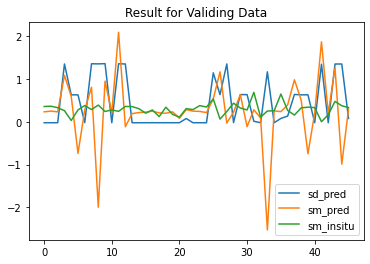

[4.424609661102295]
Epoch [13/5000] (LR: 0.0001):
Train loss: 5.1511 || Train physical loss: 1.5128 || Train eds loss: 3.6383
Valid loss: 4.4246 || Valid physical loss: 0.5959 || Valid eds loss: 3.8287
sd_pred: tensor([ 0.1183,  1.2481,  0.0597, -0.0218, -0.0211, -0.0218,  1.4589, -0.0213,
        -0.0211,  1.4506, -0.0213, -0.0218,  1.2340, -0.0218,  0.0567,  0.6904,
        -0.0218, -0.0218,  0.7138, -0.0211,  0.6442, -0.0218,  1.4401,  0.0173,
        -0.0218, -0.0187,  1.4534,  1.4500,  1.4556, -0.0187,  1.4527, -0.0218,
         0.6435,  0.6501,  1.4559, -0.0213, -0.0211,  0.0594,  1.4559])


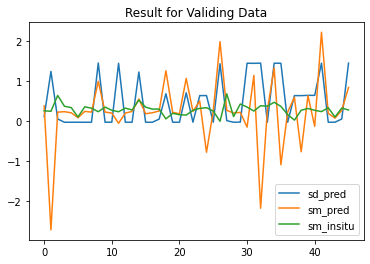

[4.306515216827393]
Epoch [14/5000] (LR: 0.0001):
Train loss: 4.9632 || Train physical loss: 1.1119 || Train eds loss: 3.8513
Valid loss: 4.3065 || Valid physical loss: 0.6786 || Valid eds loss: 3.6279
Saving model with loss 4.307...
sd_pred: tensor([ 0.1099, -0.0203,  0.7077,  1.5811,  1.5912, -0.0191, -0.0050,  0.7014,
        -0.0203, -0.0203, -0.0196,  1.3676,  1.5806,  1.5869, -0.0049,  1.5956,
        -0.0203, -0.0203,  0.1096, -0.0196,  0.1668,  1.5933, -0.0203, -0.0191,
         0.8426, -0.0191,  0.7996,  1.5869,  1.5925, -0.0196, -0.0203,  0.0293,
         1.5715, -0.0203,  0.7006,  0.1067, -0.0203, -0.0191,  1.3738])


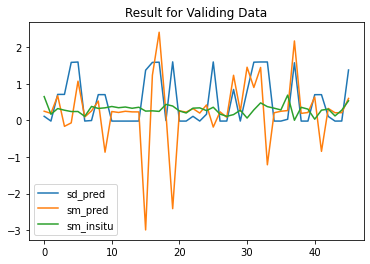

[4.182277202606201]
Epoch [15/5000] (LR: 0.0001):
Train loss: 5.0954 || Train physical loss: 1.3671 || Train eds loss: 3.7282
Valid loss: 4.1823 || Valid physical loss: 0.8132 || Valid eds loss: 3.3691
Saving model with loss 4.182...
sd_pred: tensor([ 0.1613,  0.2159,  1.4686,  0.1581, -0.0181, -0.0181,  1.4943, -0.0170,
         1.6992, -0.0181,  0.8992, -0.0170,  1.7108,  1.6924,  0.1616, -0.0181,
         0.0104,  0.7444,  1.7078,  0.0101,  1.7085, -0.0181,  1.7032, -0.0181,
         1.6991,  0.7453, -0.0170, -0.0163, -0.0181, -0.0164, -0.0181,  0.9594,
        -0.0164,  0.7523,  0.0453, -0.0181,  1.6930,  1.6833, -0.0164])


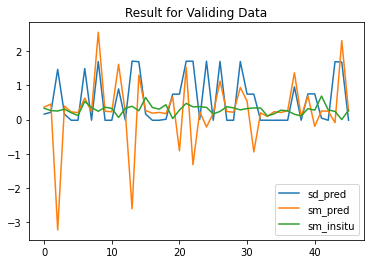

[4.1095733642578125]
Epoch [16/5000] (LR: 0.0001):
Train loss: 4.7800 || Train physical loss: 1.1549 || Train eds loss: 3.6251
Valid loss: 4.1096 || Valid physical loss: 0.9372 || Valid eds loss: 3.1724
Saving model with loss 4.110...
sd_pred: tensor([ 1.8624,  1.8895,  1.6778, -0.0176,  0.2588, -0.0176, -0.0176, -0.0162,
         1.1390, -0.0153, -0.0176,  1.0576, -0.0154,  0.8419,  1.6330, -0.0162,
         0.0204, -0.0176,  0.2549,  0.0585, -0.0176, -0.0176,  0.0204,  1.8817,
         0.8494,  1.8773,  0.8409,  1.8773, -0.0154,  1.8901, -0.0176,  1.8709,
         0.3097, -0.0176,  0.2591, -0.0154,  1.8715,  1.8925, -0.0162])


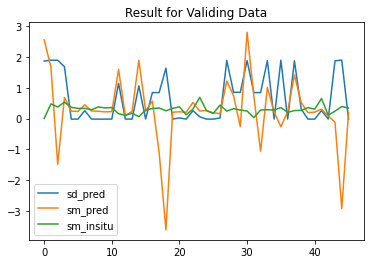

[4.045280456542969]
Epoch [17/5000] (LR: 0.0001):
Train loss: 4.4237 || Train physical loss: 1.0259 || Train eds loss: 3.3979
Valid loss: 4.0453 || Valid physical loss: 1.1601 || Valid eds loss: 2.8851
Saving model with loss 4.045...
sd_pred: tensor([-0.0174,  1.9831,  1.9987,  0.3246,  0.3286,  1.9964,  1.2661, -0.0174,
         0.0707, -0.0145,  0.3290,  0.8831,  0.3725, -0.0174,  0.8841,  1.9831,
        -0.0174,  0.0306, -0.0174, -0.0156, -0.0156, -0.0155, -0.0145, -0.0173,
         1.9770,  1.9676, -0.0173,  1.1635,  1.7901,  1.7237,  0.0305, -0.0174,
        -0.0145,  1.9764, -0.0174, -0.0145,  1.9957,  1.9876,  0.8919])


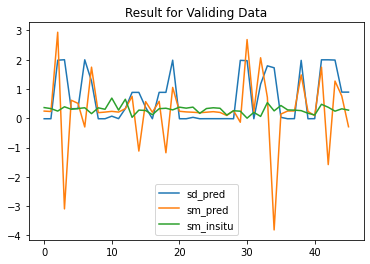

[4.034704685211182]
Epoch [18/5000] (LR: 0.0001):
Train loss: 4.9129 || Train physical loss: 1.8492 || Train eds loss: 3.0637
Valid loss: 4.0347 || Valid physical loss: 1.3014 || Valid eds loss: 2.7333
Saving model with loss 4.035...
sd_pred: tensor([-0.0123,  0.3621,  2.0302, -0.0163,  0.8738, -0.0163,  0.8728,  1.3451,
        -0.0163, -0.0163, -0.0137, -0.0157,  2.0326,  1.9995,  1.7454,  2.0188,
         2.0148, -0.0138, -0.0163,  2.0295, -0.0123,  2.0091,  0.3981, -0.0163,
         0.3576,  0.0720, -0.0163, -0.0138, -0.0157,  2.0148,  0.0337, -0.0123,
         1.2187,  2.0085, -0.0123,  0.3617,  1.8325,  0.0338,  0.8815])


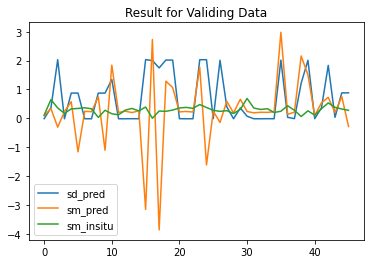

[4.034986972808838]
Epoch [19/5000] (LR: 0.0001):
Train loss: 4.5964 || Train physical loss: 1.5967 || Train eds loss: 2.9997
Valid loss: 4.0350 || Valid physical loss: 1.3457 || Valid eds loss: 2.6892
sd_pred: tensor([ 1.8708,  1.8739, -0.0130, -0.0177, -0.0168,  0.2939,  1.8452, -0.0130,
         0.0385,  1.8714,  0.0382, -0.0147,  1.8457,  1.8374, -0.0177,  1.5825,
         1.1296, -0.0177,  1.8507,  0.2935,  0.3212,  0.0790, -0.0130,  1.8508,
         1.6955, -0.0130,  0.7249, -0.0147, -0.0177, -0.0168,  0.7173,  0.2895,
         1.8546, -0.0177, -0.0177, -0.0147,  0.7164, -0.0177,  1.2782])


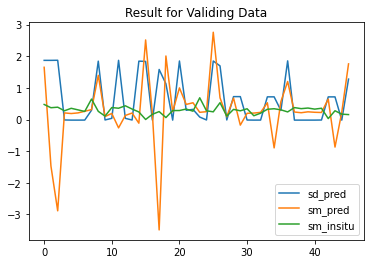

[4.0392045974731445]
Epoch [20/5000] (LR: 0.0001):
Train loss: 4.9920 || Train physical loss: 1.9754 || Train eds loss: 3.0166
Valid loss: 4.0392 || Valid physical loss: 1.1227 || Valid eds loss: 2.9165
sd_pred: tensor([ 0.2145, -0.0198,  0.2183,  0.2364, -0.0145,  0.5600,  0.0465,  0.0924,
        -0.0198, -0.0198,  1.6955,  1.4293,  1.2192,  0.0468,  1.6960, -0.0145,
         1.7243, -0.0198, -0.0164,  1.5656,  0.5526, -0.0185,  0.5518,  1.6883,
        -0.0145,  1.0499, -0.0164, -0.0145,  0.2187, -0.0198, -0.0185, -0.0164,
         1.7249,  1.7273, -0.0198,  1.7009, -0.0198,  1.7046,  1.7009])


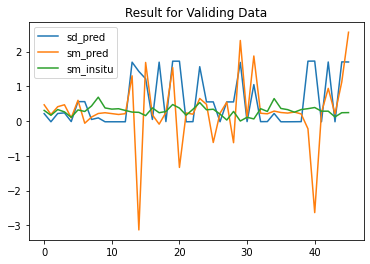

[4.0886759757995605]
Epoch [21/5000] (LR: 0.0001):
Train loss: 4.7191 || Train physical loss: 1.2977 || Train eds loss: 3.4213
Valid loss: 4.0887 || Valid physical loss: 0.9340 || Valid eds loss: 3.1546
sd_pred: tensor([-0.0215,  1.5131, -0.0215, -0.0215, -0.0154,  1.6625,  1.6600,  1.3555,
        -0.0154, -0.0198, -0.0215, -0.0198,  1.6190,  1.0284, -0.0176,  1.2230,
         1.6356,  0.1812, -0.0215,  0.1808, -0.0215,  1.6263,  0.4642,  1.6318,
         1.6318,  0.1189,  0.4570, -0.0154, -0.0176,  0.0606, -0.0215,  1.6267,
         0.1921,  0.0610,  1.6593, -0.0176,  0.1771,  0.4562, -0.0154])


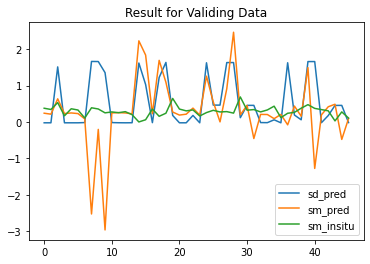

[4.128109931945801]
Epoch [22/5000] (LR: 0.0001):
Train loss: 4.8039 || Train physical loss: 1.2050 || Train eds loss: 3.5989
Valid loss: 4.1281 || Valid physical loss: 0.8563 || Valid eds loss: 3.2719
sd_pred: tensor([0.5548, 0.3287, 0.2471, 0.2979, 0.2481, 0.3547, 0.3873, 1.6597, 0.3869,
        1.5565, 0.5839, 0.5529, 0.3546, 1.3469, 0.3040, 1.6504, 1.6416, 0.3281,
        0.3021, 1.6509, 0.4268, 0.4277, 0.3271, 1.3671, 0.2527, 0.2486, 0.3031,
        1.6559, 0.1797, 1.6848, 1.6841, 1.1038, 1.6560, 0.5545, 0.4353, 0.5542,
        1.6874, 0.3024, 0.3887])


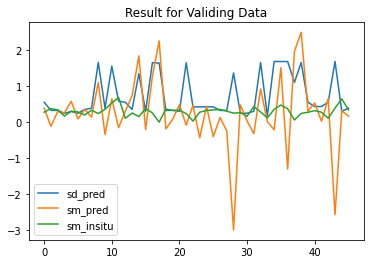

[4.7705535888671875]
Epoch [23/5000] (LR: 0.0001):
Train loss: 4.7976 || Train physical loss: 1.1875 || Train eds loss: 3.6101
Valid loss: 4.7706 || Valid physical loss: 0.9557 || Valid eds loss: 3.8149
sd_pred: tensor([-0.0618,  0.2577, -0.0618, -0.0618,  0.4397, -0.0618,  0.4783,  0.4252,
         0.4435, -0.0618, -0.0618, -0.0618, -0.0618,  0.4817, -0.0618, -0.0618,
         0.4336,  0.2001, -0.0618, -0.0618,  0.4398, -0.0618,  0.2867, -0.0618,
        -0.0618, -0.0618, -0.0618, -0.0618, -0.0618, -0.0618,  0.4342, -0.0618,
         0.0331, -0.0618, -0.0618, -0.0618, -0.0618, -0.0618,  0.4790])


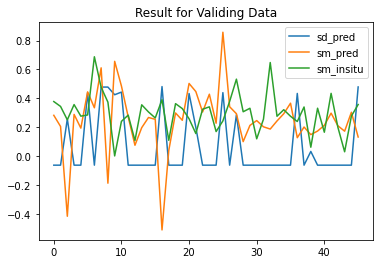

[6.868545055389404]
Epoch [24/5000] (LR: 0.0001):
Train loss: 49.6600 || Train physical loss: 45.7648 || Train eds loss: 3.8952
Valid loss: 6.8685 || Valid physical loss: 0.0670 || Valid eds loss: 6.8015
sd_pred: tensor([-0.1465, -0.1465, -0.1465, -0.1465, -0.1465, -0.1465, -0.1465, -0.1465,
        -0.1465, -0.1465, -0.1465, -0.1465, -0.1465, -0.1465, -0.1465, -0.1465,
        -0.1465, -0.1465, -0.1465, -0.1465, -0.1465, -0.1465, -0.1465, -0.1465,
        -0.1465, -0.1465, -0.1465, -0.1465, -0.1465, -0.1465, -0.1465, -0.1465,
        -0.1465, -0.1465, -0.1465, -0.1465, -0.1465, -0.1465, -0.1465])


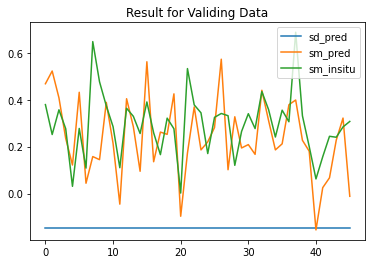

[10.02580451965332]
Epoch [25/5000] (LR: 0.0001):
Train loss: 5.2293 || Train physical loss: 1.0717 || Train eds loss: 4.1576
Valid loss: 10.0258 || Valid physical loss: 0.0258 || Valid eds loss: 10.0000
sd_pred: tensor([-0.2091, -0.2091, -0.2091, -0.2091, -0.2091, -0.2091, -0.2091, -0.2091,
        -0.2091, -0.2091, -0.2091, -0.2091, -0.2091, -0.2091, -0.2091, -0.2091,
        -0.2091, -0.2091, -0.2091, -0.2091, -0.2091, -0.2091, -0.2091, -0.2091,
        -0.2091, -0.2091, -0.2091, -0.2091, -0.2091, -0.2091, -0.2091, -0.2091,
        -0.2091, -0.2091, -0.2091, -0.2091, -0.2091, -0.2091, -0.2091])


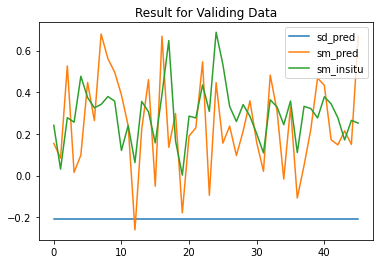

[10.040994644165039]
Epoch [26/5000] (LR: 0.0001):
Train loss: 5.0634 || Train physical loss: 0.4388 || Train eds loss: 4.6246
Valid loss: 10.0410 || Valid physical loss: 0.0410 || Valid eds loss: 10.0000
sd_pred: tensor([1.2645, 0.8498, 0.6627, 1.2724, 0.7065, 1.4038, 0.6599, 0.7547, 1.4747,
        1.3449, 1.4769, 0.6608, 1.4783, 1.4719, 1.2659, 0.7577, 1.4749, 1.2895,
        1.1053, 1.1304, 1.4016, 1.4050, 1.3448, 0.7535, 1.4760, 1.4768, 1.2882,
        1.3438, 1.4472, 0.7071, 1.4462, 1.2879, 1.4659, 1.4459, 1.2877, 1.1053,
        0.7045, 1.4036, 1.3353])


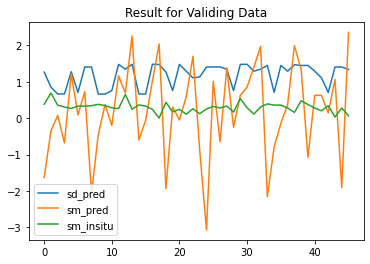

[7.269926071166992]
Epoch [27/5000] (LR: 0.0001):
Train loss: 5.5575 || Train physical loss: 0.9486 || Train eds loss: 4.6090
Valid loss: 7.2699 || Valid physical loss: 1.5557 || Valid eds loss: 5.7142
sd_pred: tensor([-0.4132, -0.4132, -0.4132, -0.4132, -0.4132, -0.4132, -0.4132, -0.4132,
        -0.4132, -0.4132, -0.4132, -0.4132, -0.4132, -0.4132, -0.4132, -0.4132,
        -0.4132, -0.4132, -0.4132, -0.4132, -0.4132, -0.4132, -0.4132, -0.4132,
        -0.4132, -0.4132, -0.4132, -0.4132, -0.4132, -0.4132, -0.4132, -0.4132,
        -0.4132, -0.4132, -0.4132, -0.4132, -0.4132, -0.4132, -0.4132])


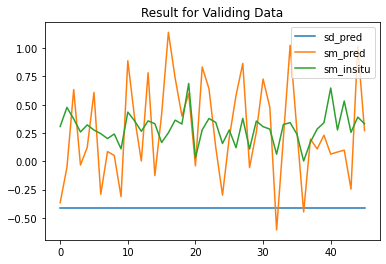

[10.139349937438965]
Epoch [28/5000] (LR: 0.0001):
Train loss: 164.9299 || Train physical loss: 158.2854 || Train eds loss: 6.6445
Valid loss: 10.1393 || Valid physical loss: 0.1393 || Valid eds loss: 10.0000
sd_pred: tensor([-0.5870, -0.5870, -0.5870, -0.5870, -0.5870, -0.5870, -0.5870, -0.5870,
        -0.5870, -0.5870, -0.5870, -0.5870, -0.5870, -0.5870, -0.5870, -0.5870,
        -0.5870, -0.5870, -0.5870, -0.5870, -0.5870, -0.5870, -0.5870, -0.5870,
        -0.5870, -0.5870, -0.5870, -0.5870, -0.5870, -0.5870, -0.5870, -0.5870,
        -0.5870, -0.5870, -0.5870, -0.5870, -0.5870, -0.5870, -0.5870])


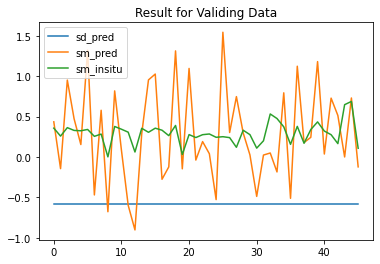

[10.282139778137207]
Epoch [29/5000] (LR: 0.0001):
Train loss: 10.3562 || Train physical loss: 0.3562 || Train eds loss: 10.0000
Valid loss: 10.2821 || Valid physical loss: 0.2821 || Valid eds loss: 10.0000
sd_pred: tensor([-0.7121, -0.7121, -0.7121, -0.7121, -0.7121, -0.7121, -0.7121, -0.7121,
        -0.7121, -0.7121, -0.7121, -0.7121, -0.7121, -0.7121, -0.7121, -0.7121,
        -0.7121, -0.7121, -0.7121, -0.7121, -0.7121, -0.7121, -0.7121, -0.7121,
        -0.7121, -0.7121, -0.7121, -0.7121, -0.7121, -0.7121, -0.7121, -0.7121,
        -0.7121, -0.7121, -0.7121, -0.7121, -0.7121, -0.7121, -0.7121])


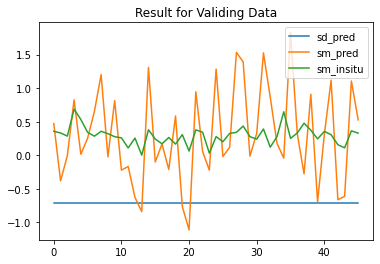

[10.418341636657715]
Epoch [30/5000] (LR: 0.0001):
Train loss: 10.9398 || Train physical loss: 0.9398 || Train eds loss: 10.0000
Valid loss: 10.4183 || Valid physical loss: 0.4183 || Valid eds loss: 10.0000
sd_pred: tensor([-0.7013, -0.7013, -0.7013, -0.7013, -0.7013, -0.7013, -0.7013, -0.7013,
        -0.7013, -0.7013, -0.7013, -0.7013, -0.7013, -0.7013, -0.7013, -0.7013,
        -0.7013, -0.7013, -0.7013, -0.7013, -0.7013, -0.7013, -0.7013, -0.7013,
        -0.7013, -0.7013, -0.7013, -0.7013, -0.7013, -0.7013, -0.7013, -0.7013,
        -0.7013, -0.7013, -0.7013, -0.7013, -0.7013, -0.7013, -0.7013])


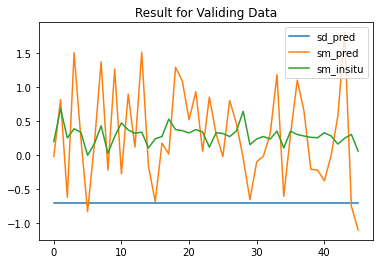

[10.405464172363281]
Epoch [31/5000] (LR: 0.0001):
Train loss: 54.6229 || Train physical loss: 44.6229 || Train eds loss: 10.0000
Valid loss: 10.4055 || Valid physical loss: 0.4055 || Valid eds loss: 10.0000
sd_pred: tensor([-0.6552, -0.6552, -0.6552, -0.6552, -0.6552, -0.6552, -0.6552, -0.6552,
        -0.6552, -0.6552, -0.6552, -0.6552, -0.6552, -0.6552, -0.6552, -0.6552,
        -0.6552, -0.6552, -0.6552, -0.6552, -0.6552, -0.6552, -0.6552, -0.6552,
        -0.6552, -0.6552, -0.6552, -0.6552, -0.6552, -0.6552, -0.6552, -0.6552,
        -0.6552, -0.6552, -0.6552, -0.6552, -0.6552, -0.6552, -0.6552])


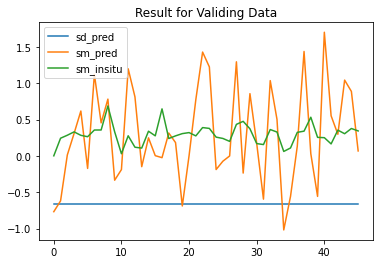

[10.352907180786133]
Epoch [32/5000] (LR: 0.0001):
Train loss: 52.3326 || Train physical loss: 42.3326 || Train eds loss: 10.0000
Valid loss: 10.3529 || Valid physical loss: 0.3529 || Valid eds loss: 10.0000
sd_pred: tensor([-0.5579, -0.5579, -0.5579, -0.5579, -0.5579, -0.5579, -0.5579, -0.5579,
        -0.5579, -0.5579, -0.5579, -0.5579, -0.5579, -0.5579, -0.5579, -0.5579,
        -0.5579, -0.5579, -0.5579, -0.5579, -0.5579, -0.5579, -0.5579, -0.5579,
        -0.5579, -0.5579, -0.5579, -0.5579, -0.5579, -0.5579, -0.5579, -0.5579,
        -0.5579, -0.5579, -0.5579, -0.5579, -0.5579, -0.5579, -0.5579])


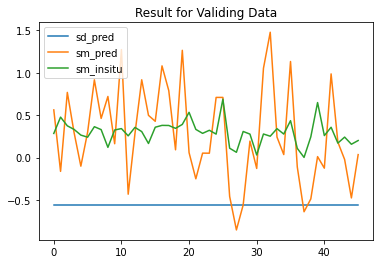

[10.254406929016113]
Epoch [33/5000] (LR: 0.0001):
Train loss: 10.8320 || Train physical loss: 0.8320 || Train eds loss: 10.0000
Valid loss: 10.2544 || Valid physical loss: 0.2544 || Valid eds loss: 10.0000
sd_pred: tensor([-0.5217, -0.5217, -0.5217, -0.5217, -0.5217, -0.5217, -0.5217, -0.5217,
        -0.5217, -0.5217, -0.5217, -0.5217, -0.5217, -0.5217, -0.5217, -0.5217,
        -0.5217, -0.5217, -0.5217, -0.5217, -0.5217, -0.5217, -0.5217, -0.5217,
        -0.5217, -0.5217, -0.5217, -0.5217, -0.5217, -0.5217, -0.5217, -0.5217,
        -0.5217, -0.5217, -0.5217, -0.5217, -0.5217, -0.5217, -0.5217])


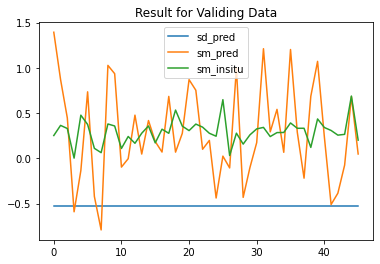

[10.22215461730957]
Epoch [34/5000] (LR: 5e-05):
Train loss: 10.6455 || Train physical loss: 0.6455 || Train eds loss: 10.0000
Valid loss: 10.2222 || Valid physical loss: 0.2222 || Valid eds loss: 10.0000
sd_pred: tensor([-0.4578, -0.4578, -0.4578, -0.4578, -0.4578, -0.4578, -0.4578, -0.4578,
        -0.4578, -0.4578, -0.4578, -0.4578, -0.4578, -0.4578, -0.4578, -0.4578,
        -0.4578, -0.4578, -0.4578, -0.4578, -0.4578, -0.4578, -0.4578, -0.4578,
        -0.4578, -0.4578, -0.4578, -0.4578, -0.4578, -0.4578, -0.4578, -0.4578,
        -0.4578, -0.4578, -0.4578, -0.4578, -0.4578, -0.4578, -0.4578])


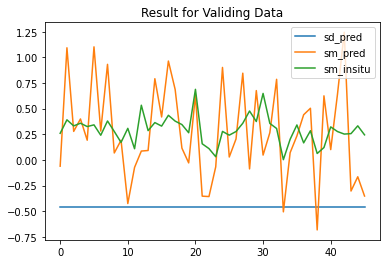

[10.1708402633667]
Epoch [35/5000] (LR: 5e-05):
Train loss: 33.8914 || Train physical loss: 23.8914 || Train eds loss: 10.0000
Valid loss: 10.1708 || Valid physical loss: 0.1708 || Valid eds loss: 10.0000
sd_pred: tensor([-0.3892, -0.3892, -0.3892, -0.3892, -0.3892, -0.3892, -0.3892, -0.3892,
        -0.3892, -0.3892, -0.3892, -0.3892, -0.3892, -0.3892, -0.3892, -0.3892,
        -0.3892, -0.3892, -0.3892, -0.3892, -0.3892, -0.3892, -0.3892, -0.3892,
        -0.3892, -0.3892, -0.3892, -0.3892, -0.3892, -0.3892, -0.3892, -0.3892,
        -0.3892, -0.3892, -0.3892, -0.3892, -0.3892, -0.3892, -0.3892])


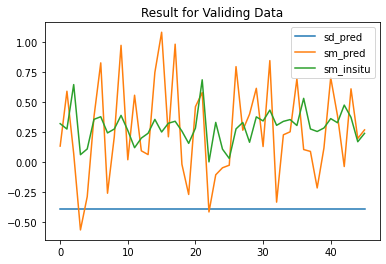

[10.12392520904541]
Epoch [36/5000] (LR: 5e-05):
Train loss: 26.8594 || Train physical loss: 16.8594 || Train eds loss: 10.0000
Valid loss: 10.1239 || Valid physical loss: 0.1239 || Valid eds loss: 10.0000
sd_pred: tensor([-0.3296, -0.3296, -0.3296, -0.3296, -0.3296, -0.3296, -0.3296, -0.3296,
        -0.3296, -0.3296, -0.3296, -0.3296, -0.3296, -0.3296, -0.3296, -0.3296,
        -0.3296, -0.3296, -0.3296, -0.3296, -0.3296, -0.3296, -0.3296, -0.3296,
        -0.3296, -0.3296, -0.3296, -0.3296, -0.3296, -0.3296, -0.3296, -0.3296,
        -0.3296, -0.3296, -0.3296, -0.3296, -0.3296, -0.3296, -0.3296])


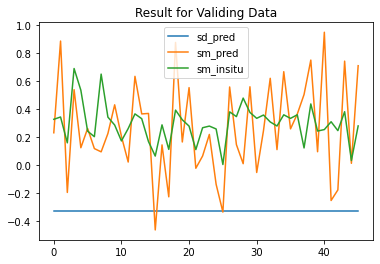

[10.090039253234863]
Epoch [37/5000] (LR: 5e-05):
Train loss: 10.1728 || Train physical loss: 0.1728 || Train eds loss: 10.0000
Valid loss: 10.0900 || Valid physical loss: 0.0900 || Valid eds loss: 10.0000
sd_pred: tensor([-0.2703, -0.2703, -0.2703, -0.2703, -0.2703, -0.2703, -0.2703, -0.2703,
        -0.2703, -0.2703, -0.2703, -0.2703, -0.2703, -0.2703, -0.2703, -0.2703,
        -0.2703, -0.2703, -0.2703, -0.2703, -0.2703, -0.2703, -0.2703, -0.2703,
        -0.2703, -0.2703, -0.2703, -0.2703, -0.2703, -0.2703, -0.2703, -0.2703,
        -0.2703, -0.2703, -0.2703, -0.2703, -0.2703, -0.2703, -0.2703])


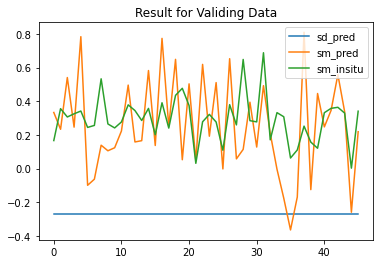

[10.06265926361084]
Epoch [38/5000] (LR: 5e-05):
Train loss: 18.5981 || Train physical loss: 8.5981 || Train eds loss: 10.0000
Valid loss: 10.0627 || Valid physical loss: 0.0627 || Valid eds loss: 10.0000
sd_pred: tensor([-0.2143, -0.2143, -0.2143, -0.2143, -0.2143, -0.2143, -0.2143, -0.2143,
        -0.2143, -0.2143, -0.2143, -0.2143, -0.2143, -0.2143, -0.2143, -0.2143,
        -0.2143, -0.2143, -0.2143, -0.2143, -0.2143, -0.2143, -0.2143, -0.2143,
        -0.2143, -0.2143, -0.2143, -0.2143, -0.2143, -0.2143, -0.2143, -0.2143,
        -0.2143, -0.2143, -0.2143, -0.2143, -0.2143, -0.2143, -0.2143])


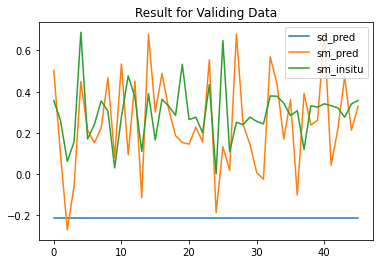

[10.042569160461426]
Epoch [39/5000] (LR: 5e-05):
Train loss: 14.8140 || Train physical loss: 4.8140 || Train eds loss: 10.0000
Valid loss: 10.0426 || Valid physical loss: 0.0426 || Valid eds loss: 10.0000
sd_pred: tensor([-0.1534, -0.1534, -0.1534, -0.1534, -0.1534, -0.1534, -0.1534, -0.1534,
        -0.1534, -0.1534, -0.1534, -0.1534, -0.1534, -0.1534, -0.1534, -0.1534,
        -0.1534, -0.1534, -0.1534, -0.1534, -0.1534, -0.1534, -0.1534, -0.1534,
        -0.1534, -0.1534, -0.1534, -0.1534, -0.1534, -0.1534, -0.1534, -0.1534,
        -0.1534, -0.1534, -0.1534, -0.1534, -0.1534, -0.1534, -0.1534])


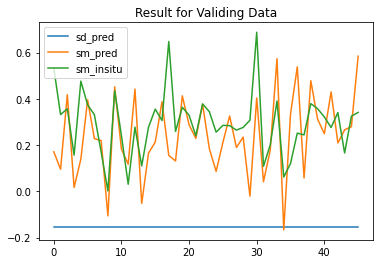

[10.027122497558594]
Epoch [40/5000] (LR: 5e-05):
Train loss: 13.3205 || Train physical loss: 3.3205 || Train eds loss: 10.0000
Valid loss: 10.0271 || Valid physical loss: 0.0271 || Valid eds loss: 10.0000
sd_pred: tensor([-0.0980, -0.0980, -0.0980, -0.0980, -0.0980, -0.0980, -0.0980, -0.0980,
        -0.0980, -0.0980, -0.0980, -0.0980, -0.0980, -0.0980, -0.0980, -0.0980,
        -0.0980, -0.0980, -0.0980, -0.0980, -0.0980, -0.0980, -0.0980, -0.0980,
        -0.0980, -0.0980, -0.0980, -0.0980, -0.0980, -0.0980, -0.0980, -0.0980,
        -0.0980, -0.0980, -0.0980, -0.0980, -0.0980, -0.0980, -0.0980])


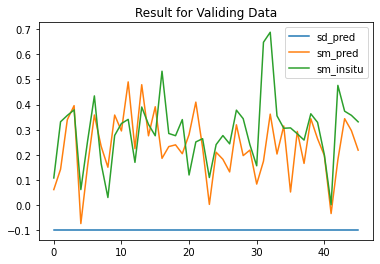

[10.018864631652832]
Epoch [41/5000] (LR: 5e-05):
Train loss: 11.6139 || Train physical loss: 1.6139 || Train eds loss: 10.0000
Valid loss: 10.0189 || Valid physical loss: 0.0189 || Valid eds loss: 10.0000
sd_pred: tensor([-0.0480, -0.0480, -0.0480, -0.0480, -0.0480, -0.0480, -0.0480, -0.0480,
        -0.0480, -0.0480, -0.0480, -0.0480, -0.0480, -0.0480, -0.0480, -0.0480,
        -0.0480, -0.0480, -0.0480, -0.0480, -0.0480, -0.0480, -0.0480, -0.0480,
        -0.0480, -0.0480, -0.0480, -0.0480, -0.0480, -0.0480, -0.0480, -0.0480,
        -0.0480, -0.0480, -0.0480, -0.0480, -0.0480, -0.0480, -0.0480])


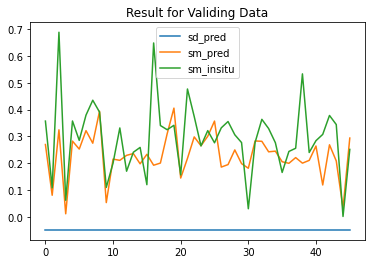

[10.016128540039062]
Epoch [42/5000] (LR: 5e-05):
Train loss: 10.8403 || Train physical loss: 0.8403 || Train eds loss: 10.0000
Valid loss: 10.0161 || Valid physical loss: 0.0161 || Valid eds loss: 10.0000
sd_pred: tensor([-0.0082, -0.0082, -0.0082, -0.0082, -0.0082, -0.0082, -0.0082, -0.0082,
        -0.0082, -0.0082, -0.0082, -0.0082, -0.0082, -0.0082, -0.0082, -0.0082,
        -0.0082, -0.0082, -0.0082, -0.0082, -0.0082, -0.0082, -0.0082, -0.0082,
        -0.0082, -0.0082, -0.0082, -0.0082, -0.0082, -0.0082, -0.0082, -0.0082,
        -0.0082, -0.0082, -0.0082, -0.0082, -0.0082, -0.0082, -0.0082])


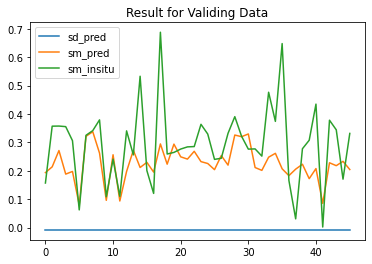

[10.017163276672363]
Epoch [43/5000] (LR: 5e-05):
Train loss: 10.2121 || Train physical loss: 0.2121 || Train eds loss: 10.0000
Valid loss: 10.0172 || Valid physical loss: 0.0172 || Valid eds loss: 10.0000
sd_pred: tensor([0.0206, 0.0206, 0.0206, 0.0206, 0.0206, 0.0206, 0.0206, 0.0206, 0.0206,
        0.0206, 0.0206, 0.0206, 0.0206, 0.0206, 0.0206, 0.0206, 0.0206, 0.0206,
        0.0206, 0.0206, 0.0206, 0.0206, 0.0206, 0.0206, 0.0206, 0.0206, 0.0206,
        0.0206, 0.0206, 0.0206, 0.0206, 0.0206, 0.0206, 0.0206, 0.0206, 0.0206,
        0.0206, 0.0206, 0.0206])


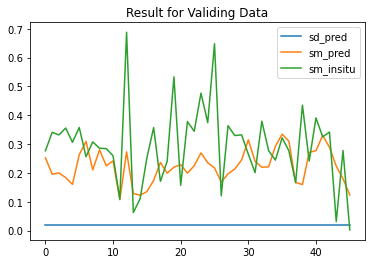

[10.01967716217041]
Epoch [44/5000] (LR: 5e-05):
Train loss: 10.0343 || Train physical loss: 0.0343 || Train eds loss: 10.0000
Valid loss: 10.0197 || Valid physical loss: 0.0197 || Valid eds loss: 10.0000
sd_pred: tensor([0.0394, 0.0394, 0.0394, 0.0394, 0.0394, 0.0394, 0.0394, 0.0394, 0.0394,
        0.0394, 0.0394, 0.0394, 0.0394, 0.0394, 0.0394, 0.0394, 0.0394, 0.0394,
        0.0394, 0.0394, 0.0394, 0.0394, 0.0394, 0.0394, 0.0394, 0.0394, 0.0394,
        0.0394, 0.0394, 0.0394, 0.0394, 0.0394, 0.0394, 0.0394, 0.0394, 0.0394,
        0.0394, 0.0394, 0.0394])


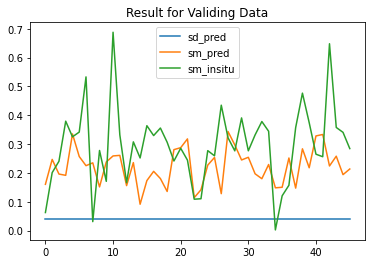

[10.022135734558105]
Epoch [45/5000] (LR: 5e-05):
Train loss: 10.0941 || Train physical loss: 0.0941 || Train eds loss: 10.0000
Valid loss: 10.0221 || Valid physical loss: 0.0221 || Valid eds loss: 10.0000


In [ ]:
if config['is_train']==True:
    print(train_dataset.get_input_shape(0))
    model = SMCNN(input_channel=train_dataset.get_input_shape(0)[2]).to(device) # put your model and data on the same computation device.
    print(model)
    trainer(train_loader, valid_loader, model, config, device)

## Testing

In [ ]:
def tester(test_loader, model, config, device):
    criterion = physics_loss # Define your loss function, do not modify this.
    model.eval() # Set your model to evaluation mode.
    loss_record = []
    pred_list = []
    for data_pkg in test_loader:
        x = data_pkg['processed_data']
#         x, y = x.to(device), y.to(device)   # Move your data to device. 
        with torch.no_grad():
            pred = model(x)
            loss = criterion(pred, data_pkg['label_data'], config['test_batch_size'], 'Testing')
        loss_record.append(loss.item())
        pred_list.append(pred.item())
    mean_test_loss = sum(loss_record)/len(loss_record)
    print(len(loss_record))
    print(mean_test_loss)
    for x in pred_list:
        print(x)
#     print(loss_record)  
    return loss_record, pred_list

In [ ]:
param_path = os.path.join(config['root'],'OUTPUT\\MODELS\\CNN\\output.ckpt' )
model = SMCNN(input_channel=train_dataset.get_input_shape(0)[2]).to(device)
model.load_state_dict(torch.load(param_path))
loss_record, pred_list = tester(test_loader, model, config, device) 

In [ ]:
plt.plot(pred_list)
# 添加标题和标签
plt.title('Prediction of SM Standard Devation')
# plt.xlabel('Index of Model')
plt.ylabel('SM Standard Devation')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# 将数据转换为DataFrame格式
df = pd.DataFrame(loss_record, columns=['MSE'])

# 绘制小提琴图
sns.violinplot(y='MSE', data=df, scale='count')
# sns.barplot(y='MSE', data=df)
# 添加标题和标签
plt.title('Distribution of MSE')
# plt.xlabel('Index of Model')
plt.ylabel('MSE Value')

# 显示图形
plt.savefig(config['root'] + 'OUTPUT\\IMAGE\\DATAVISUALIZE\\CNN\\' + str(config['seed']) + '\\' + 'MSEDistribution.png', dpi=600, transparent=False)    
plt.show()